# Example Omaha Game

We play a single Omaha game using built-in players and then try to figure out which one has the best strategy in the long run.

All the imports are centralized in the cell below.

In [1]:
from maverick import Game, PlayerLike, PlayerState
from maverick.players import FoldBot, CallBot, AggressiveBot
from maverick.rules import PokerRules, DealingRules, StakesRules, ShowdownRules
import logging
from functools import partial
import matplotlib.pyplot as plt

## Set Up Rules for Omaha

In [2]:
rules = PokerRules(
    name="Omaha",
    dealing=DealingRules(
        variant="omaha",
        hole_cards=4,
    ),
    stakes=StakesRules(
        small_blind=10,
        big_blind=20,
    ),
    showdown=ShowdownRules(
        hole_cards_required=2,
    ),
)

## Play a Single Game

In [3]:
# Configure logging such that we only get the log messages of the game
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
)
logging.getLogger().setLevel(logging.WARNING)  # Set root logger to WARNING
logging.getLogger("maverick").setLevel(logging.DEBUG)  # Only maverick logs at DEBUG

# Create game with blinds
game = Game(rules=rules, max_hands=40)

# Create and add players with different strategies
players: list[PlayerLike] = [
    CallBot(id="p1", name="CallBot", state=PlayerState(stack=1000)),
    AggressiveBot(id="p2", name="AggroBot", state=PlayerState(stack=1000)),
    FoldBot(id="p3", name="FoldBot", state=PlayerState(stack=1000)),
]

for player in players:
    game.add_player(player)

game.start()

2026-01-15 23:26:20,720 [INFO] maverick: Player CallBot joined the game.
2026-01-15 23:26:20,722 [INFO] maverick: Player AggroBot joined the game.
2026-01-15 23:26:20,723 [INFO] maverick: Player FoldBot joined the game.
2026-01-15 23:26:20,725 [INFO] maverick: Game started.

2026-01-15 23:26:20,726 [INFO] maverick: ============================== Hand 1 ==============================

2026-01-15 23:26:20,728 [INFO] maverick: PRE_FLOP | Dealing hole cards. Button: CallBot
2026-01-15 23:26:20,728 [INFO] maverick: PRE_FLOP | Posting small blind of 10 by player AggroBot. Remaining stack: 990
2026-01-15 23:26:20,729 [INFO] maverick: PRE_FLOP | Posting big blind of 20 by player FoldBot. Remaining stack: 980
2026-01-15 23:26:20,729 [INFO] maverick: PRE_FLOP | Player CallBot calls with amount 20. Remaining stack: 980.
2026-01-15 23:26:20,729 [INFO] maverick: PRE_FLOP | Current pot: 50 | Current bet: 20
2026-01-15 23:26:20,730 [INFO] maverick: PRE_FLOP | Player AggroBot raises by 30 (call: 10, r

You can print the final stacks of the players using the original list of players:

In [4]:
for player in players:
    print(f"{player.name} - Stack: {player.state.stack}")

CallBot - Stack: 1050
AggroBot - Stack: 1360
FoldBot - Stack: 590


You can also use the state for this, but be aware that it only includes players who actually have some stack. If a player got eliminated, it wont apper in the following listing.

In [5]:
for player in game.state.players:
    print(f"{player.name} - Stack: {player.state.stack}")

CallBot - Stack: 1050
AggroBot - Stack: 1360
FoldBot - Stack: 590


You can inspect the whole history of the game. In the next code block we filter for events that represent some action of a player.

In [6]:
list(filter(lambda x: x.action is not None, game.game_history))

[GameEvent(id='f335748ff52c4293bbe919e5a8cec331', ts=1768515980.730043, type=<GameEventType.PLAYER_ACTION: 9>, hand_number=1, street=<Street.PRE_FLOP: 0>, player_id='p1', action=PlayerAction(player_id='p1', action_type=<ActionType.CALL: 3>, amount=None), payload={}),
 GameEvent(id='1961154c222e4f779a7e77a2cb3d97b4', ts=1768515980.73054, type=<GameEventType.PLAYER_ACTION: 9>, hand_number=1, street=<Street.PRE_FLOP: 0>, player_id='p2', action=PlayerAction(player_id='p2', action_type=<ActionType.RAISE: 5>, amount=30), payload={}),
 GameEvent(id='151f6dc842504797a508ac8675c7b846', ts=1768515980.730954, type=<GameEventType.PLAYER_ACTION: 9>, hand_number=1, street=<Street.PRE_FLOP: 0>, player_id='p3', action=PlayerAction(player_id='p3', action_type=<ActionType.FOLD: 1>, amount=None), payload={}),
 GameEvent(id='315a57c0782f4613913ed70d7b7cd8b2', ts=1768515980.731641, type=<GameEventType.PLAYER_ACTION: 9>, hand_number=1, street=<Street.PRE_FLOP: 0>, player_id='p1', action=PlayerAction(player_

## Find the best player

We are going to find the best player by playing lots of games with the same players as before and calculating their average payoff.

For this, we first need to wrap up the game in a function that we can call in a loop.

In [7]:
# We don't want too much logging output for this example
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
)
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger("maverick").setLevel(logging.WARNING)


# Function to play a game with specified parameters
def play_game(
    small_blind:int=10, 
    big_blind:int=20, 
    max_hands:int=40,
    initial_stack:int=1000
) -> tuple[list[PlayerLike],Game]:
    game = Game(small_blind=small_blind, big_blind=big_blind, max_hands=max_hands)

    players: list[PlayerLike] = [
        CallBot(id="p1", name="CallBot", state=PlayerState(stack=initial_stack, seat=0)),
        AggressiveBot(id="p2", name="AggroBot", state=PlayerState(stack=initial_stack, seat=1)),
        CustomBot(id="p3", name="CustomBot", state=PlayerState(stack=initial_stack, seat=2)),
        FoldBot(id="p4", name="FoldBot", state=PlayerState(stack=initial_stack, seat=3)),
    ]

    for player in players:
        game.add_player(player)
        
    game.start()
    
    return players, game


# Test by playing a single game and printing the final stacks
players, game = play_game(small_blind=10, big_blind=20, max_hands=10, initial_stack=1000)
for player in players:
    print(f"{player.name} - Stack: {player.state.stack}")

NameError: name 'CustomBot' is not defined

Now play a bunch of games and visualize average payoffs. Here we define payoff as the final stock minus the initial stack. This means that the payoff can be negative. The reason behind this choice is that this gives a more intuitive visual representation (look at the FoldBot).

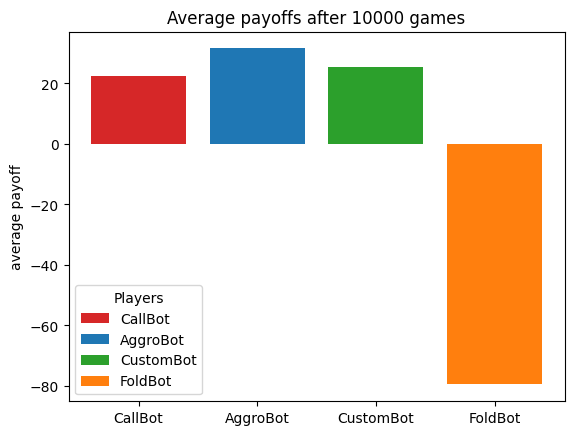

In [ ]:
# Start with a smaller number (like 100) to get a feel of execution time,
# then you can move to higher numbers like 10_000 for a more confident estimation.
n_game = 10_000

# Define game parameters
small_blind = 10
big_blind = 20
max_hands = 10         # limit the number of hands per game
initial_stack = 1000

# Create helper function with fixed parameters
play = partial(
    play_game, 
    small_blind=small_blind, 
    big_blind=big_blind, 
    max_hands=max_hands, 
    initial_stack=initial_stack
)

# Collect results
results = {p.name : [] for p in players}
for _ in range(n_game):
    players, game = play()
    for player in players:
        results[player.name].append(player.state.stack - initial_stack)

# Compute average payoffs    
average_payoffs = {name: sum(payoffs)/n_game for name, payoffs in results.items()}

# --------------------------------- Plotting ---------------------------------

fig, ax = plt.subplots()

names = []
avg_payoffs = []
for name, avg_payoff in average_payoffs.items():
    names.append(name)
    avg_payoffs.append(avg_payoff)
    
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
ax.bar(names, avg_payoffs, label=names, color=bar_colors)

ax.set_ylabel('average payoff')
ax.set_title(f'Average payoffs after {n_game} games')
ax.legend(title='Players')

plt.show()

### Findings

Here are my findings about kicking off the previous cell a number of times with 10_000 experiments:

1) CustomBot's strategy is weak on average.
2) AggroBot is typically the best performer among these players.
3) CallBot probably beats CustomBot in the long run.
4) As expected, the strategy of FoldBot leads to no good.